# Heart Failure Prediction

Link: https://www.kaggle.com/datasets/andrewmvd/heart-failure-clinical-data

## Introduccion
Se trata de un dataset con 13 atributos, 2 de estos atributos no deberian de usarse para el training (`time` y `DEATH_EVENT`) ya que significan cuando ha fallecido una persona o cuando se ha perdido el contacto con una persona y si la persona ha fallecido o no.

Este dataset se utilizo por Davide Chicco y Giuseppe Jurman en la generacion de un modelo que podia predecir la supervivencia de pacientes solamente segun su suero de creatinina y la fraccion de ejeccion.

### Objetivos
Poder predecir si una persona podria tener riesgo de fallo de corazon mortal para poder tomar las medidas necesarias para reducir la mortalidad de estos sucesos.  
Por esta razon el atributo objetivo a predecir sera `DEATH_EVENT`. A parte nos interesa tener un recall lo mas grande posible debido a la naturaleza de las predicciones clinicas.

### Manejo de outliers
Si tuviesemos un dataset mas grande podriamos eliminar los outliers mas facilmente y sin repercusiones para evitar overfitting.
En este caso, tenemos un dataset bastante pequeño (299 muestras) por lo tanto no eliminaremos ningun outlier y intentaremos obtener el recall mas grande a partir de esto. A parte estos outliers los examinaremos si no son faciles de clasificar para ver porque los valores que tienen no son normales y de esta manera intentar clasificarlos lo mejor posible.



## Cargar dataset
En este apartado cargaremos el dataset y observaremos la distribucion de los datos y las correlaciones que puede haber

In [1]:
import pandas as pd

dataframe = pd.read_csv("../../data/heart_failure_clinical_records_dataset.csv")

dataframe.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [2]:
dataframe.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


## Seleccion de datos
Despues de haber examinado las columnas del dataset se puede ver que todas estas podrian influir en el resultado, aunque no directamente.  
Mas adelante se examinarán y evaluarán numericamente las correlaciones de todos estos atributos con el atributo objetivo para poder investigarlos mas detalladamente.

## Normalizacion del dataset
Es muy importante a la hora de analizar relaciones entre datos y entrenar modelos trabajar con datos normalizados ya que de esta manera todos los datos tendran rangos parecidos y no habra atributos que pesen mas que otros, en cambio con datos no normalizados podria pasar que un atributo tenga demasiado peso al tener un valor de rangos muy alto a comparacion de otro atributo que alomejor tiene mas relacion con los datos que estamos tratando pero al tener un rango de valores muy bajo no se tiene en cuenta.

### Atributos binarios y discretos
En nuestro dataset tenemos atributos que tienen 2 posibles valores (0 y 1).  
Los atributos binarios y discretos no se deberian de normalizar como norma general, ya que estos pueden perder significado al alterarlos.  
En el caso de los binarios se deberian de mantener tal y como son.  
En el caso de los atributos discretos se deberia de hacer algun preprocesamiento de datos especial. Como nuestro dataset solo tiene atributos binarios o continuos no tendremos que preocuparnos de esto.

In [3]:
from sklearn.preprocessing import scale
columnas_a_normalizar = [0, 2, 4, 6, 7, 8]  # la columna 11 no hace falta normalizarla ya que no la usaremos
data_norm = dataframe.copy()
data_norm[data_norm.columns[columnas_a_normalizar]] = scale(data_norm[data_norm.columns[columnas_a_normalizar]])
data_norm.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,2.990000e+02,299.000000,299.000000,299.000000,2.990000e+02,299.000000,2.990000e+02,2.990000e+02,2.990000e+02,299.000000,299.00000,299.000000,299.00000
mean,5.703353e-16,0.431438,0.000000,0.418060,-3.267546e-17,0.351171,7.723291e-17,1.425838e-16,-8.673849e-16,0.648829,0.32107,130.260870,0.32107
std,1.001676e+00,0.496107,1.001676,0.494067,1.001676e+00,0.478136,1.001676e+00,1.001676e+00,1.001676e+00,0.478136,0.46767,77.614208,0.46767
min,-1.754448e+00,0.000000,-0.576918,0.000000,-2.038387e+00,0.000000,-2.440155e+00,-8.655094e-01,-5.363206e+00,0.000000,0.00000,4.000000,0.00000
25%,-8.281242e-01,0.000000,-0.480393,0.000000,-6.841802e-01,0.000000,-5.208700e-01,-4.782047e-01,-5.959961e-01,0.000000,0.00000,73.000000,0.00000
50%,-7.022315e-02,0.000000,-0.342574,0.000000,-7.076750e-03,0.000000,-1.390846e-02,-2.845524e-01,8.503384e-02,1.000000,0.00000,115.000000,0.00000
75%,7.718891e-01,1.000000,0.000166,1.000000,5.853888e-01,1.000000,4.111199e-01,5.926150e-03,7.660638e-01,1.000000,1.00000,203.000000,1.00000
max,2.877170e+00,1.000000,7.514640,1.000000,3.547716e+00,1.000000,6.008180e+00,7.752020e+00,2.582144e+00,1.000000,1.00000,285.000000,1.00000


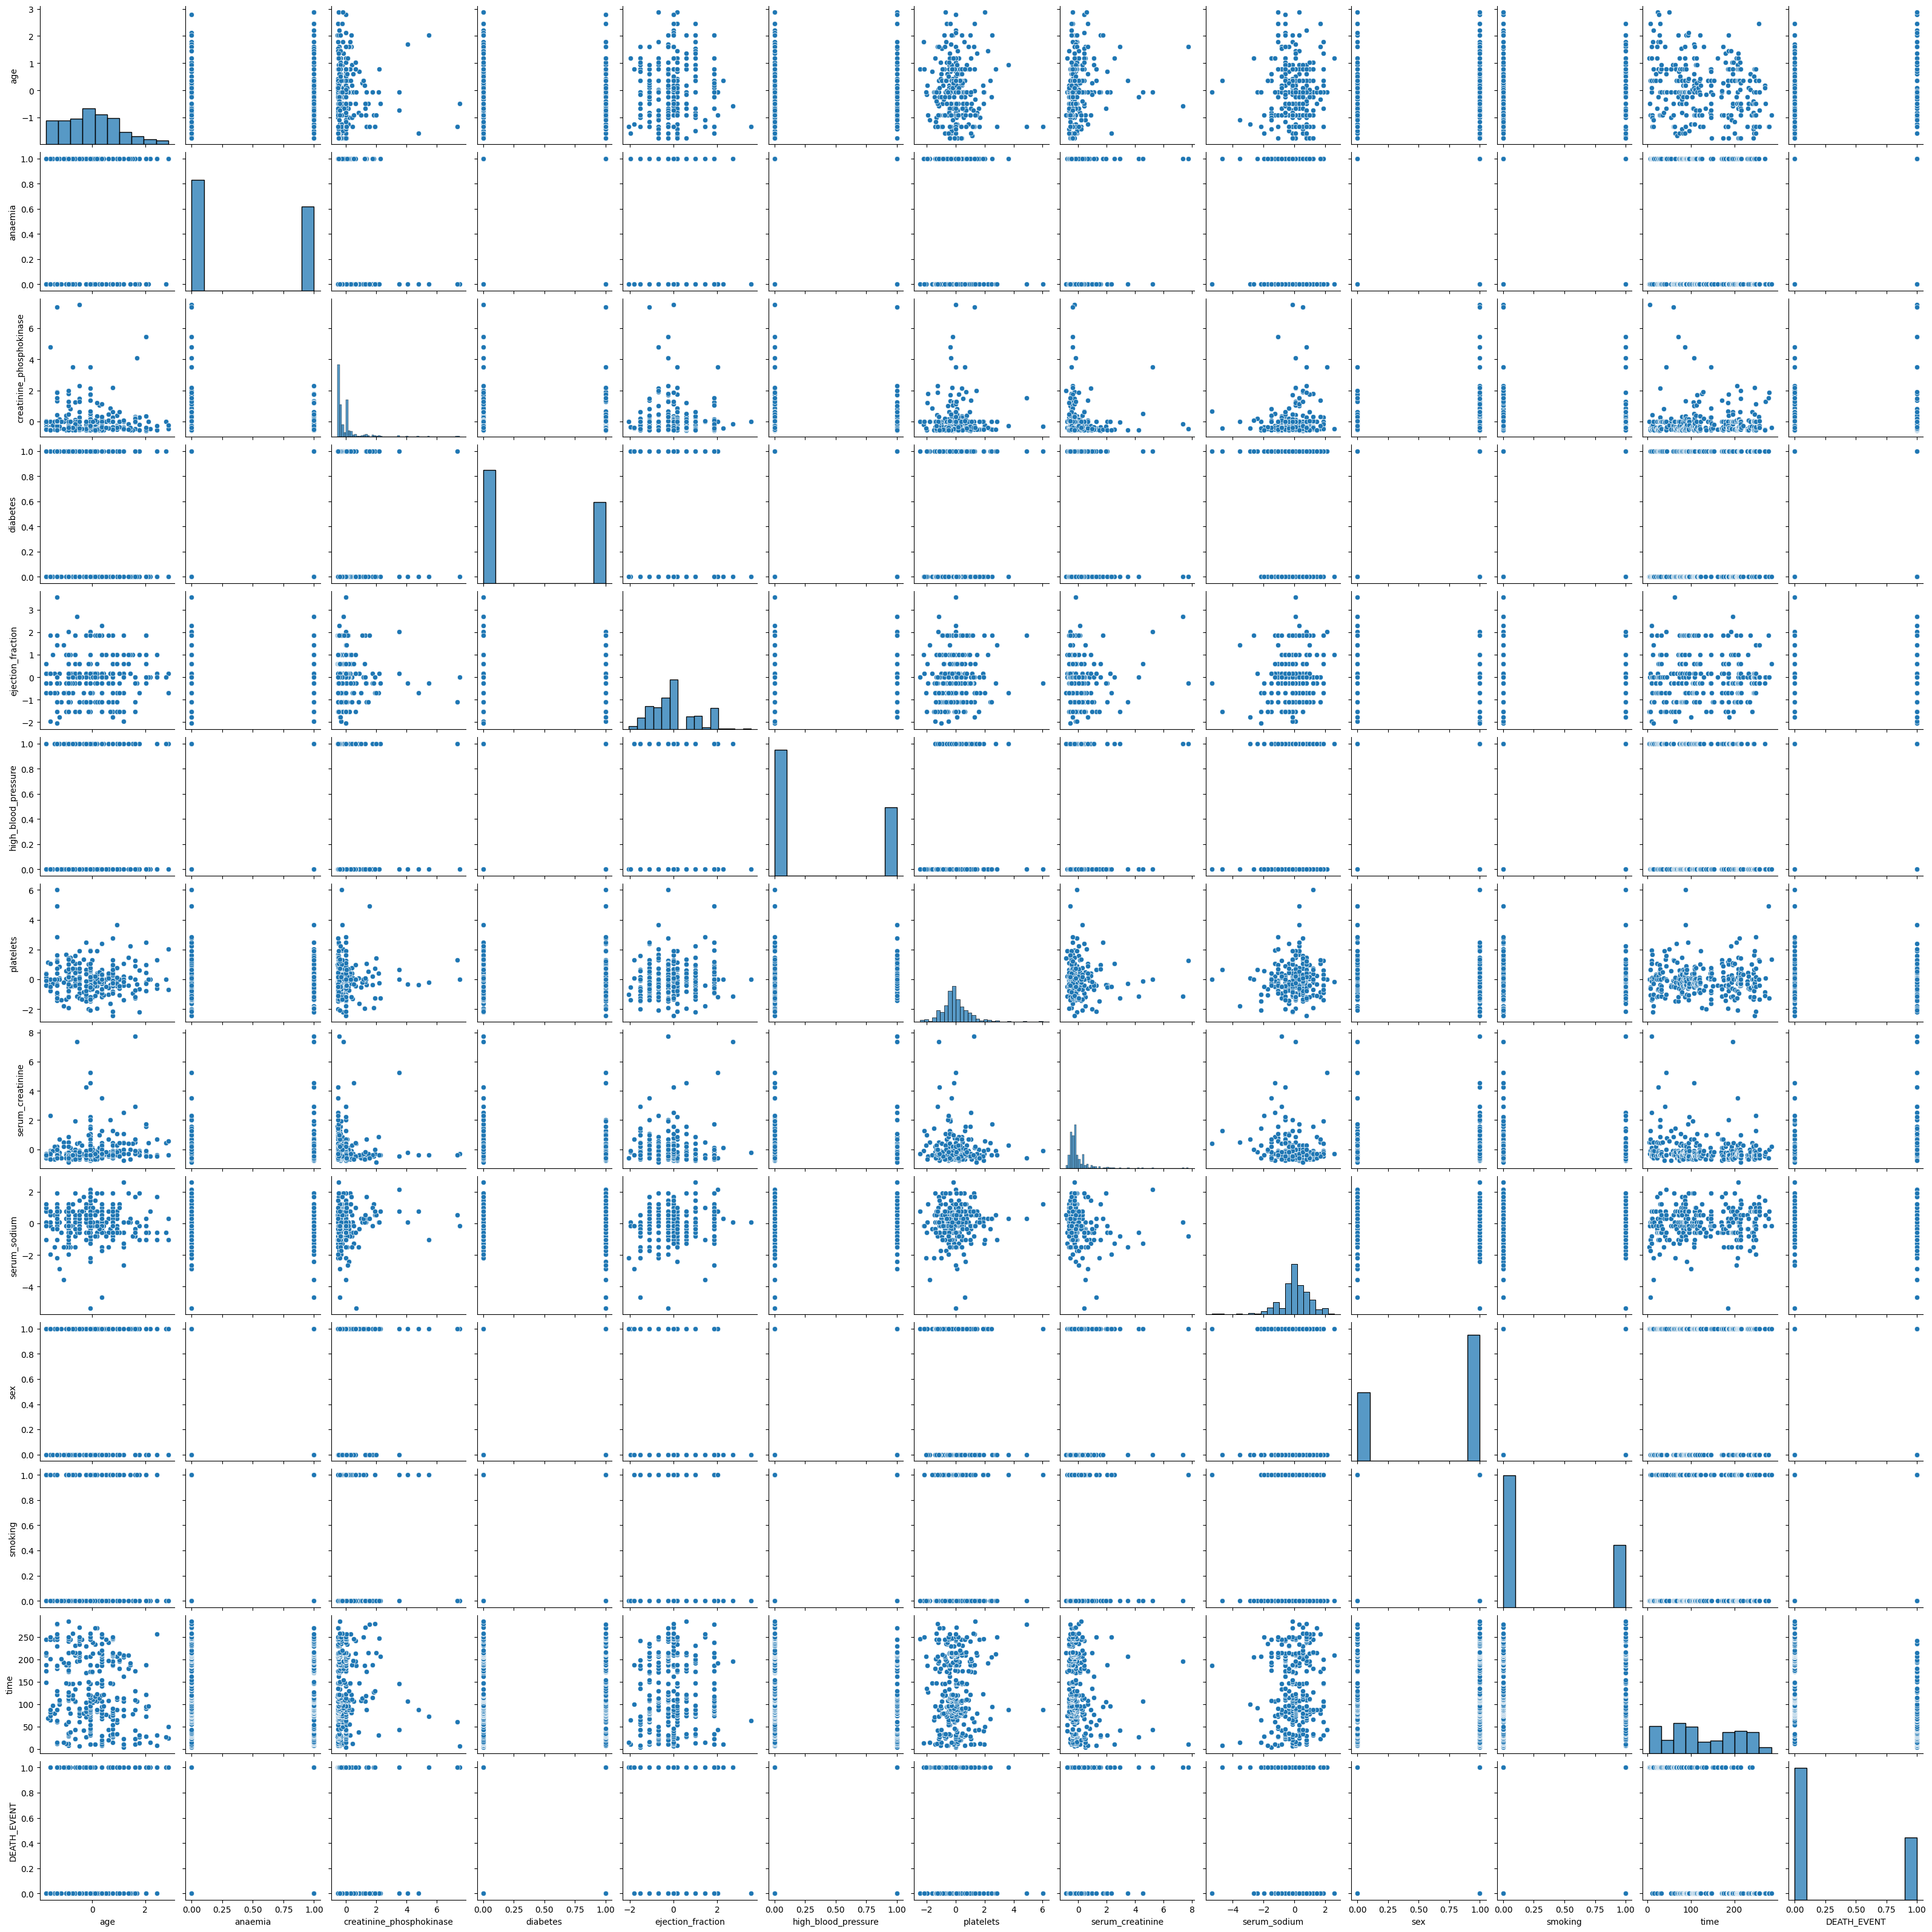

In [4]:
import seaborn as sns

sns.pairplot(data_norm)

## Pair plot
No se observa relacion clara entre atributos, tampoco es posible observar las relaciones entre atributos binarios, este tipo de atributos es mas sencillo observarlos a partir de una matriz de correlacion o visualizando la cantidad de valores que caen sobre cada uno de los 4 puntos que se pueden ver en las graficas donde ambos atributos son binarios.

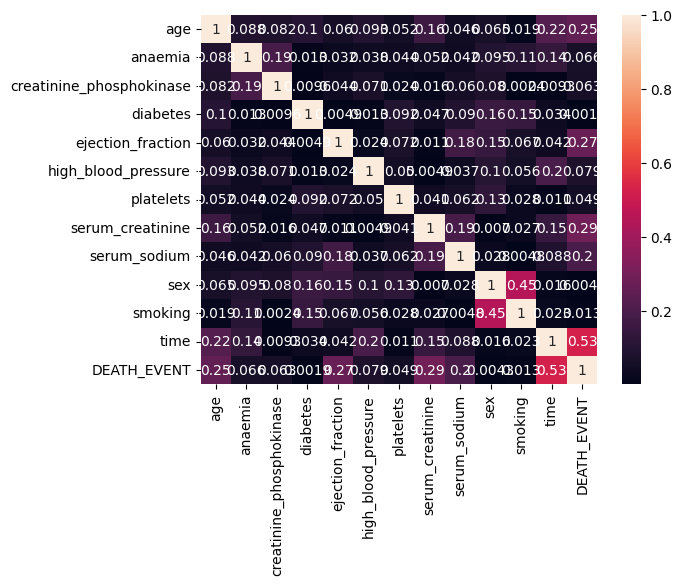

In [5]:
import matplotlib.pyplot as plt

corr = data_norm.corr()
sns.heatmap(abs(corr), annot=True)
plt.show()


## Correlacion
Se puede ver que hay relacion entre algunos atributos especificos. Los mas significativos serian:  
- Que una persona fume esta bastante correlacionado con su sexo.
- La hora a la que ha habido una fallada en el corazon tiene que ver con la mortalidad de esta fallada del corazon.

### Mortalidad
Para nuestro problema, podemos ver los atributos que mas influyen en la mortalidad de una fallada de corazon:
- La edad
- La fraccion de eyeccion
- El nivel de suero de creatinina
- El nivel de suero de sodio
- La hora de la muerte o censura (este link explica que significa esta columna y porque no vamos a utilizarla https://www.kaggle.com/datasets/andrewmvd/heart-failure-clinical-data/discussion/178372)

Curiosamente el resto de valores no estan correlacionados en tanta medida con la mortalidad pese a que uno pensaria que si, como por ejemplo si se tiene anemia o diabetes.
Otros valores en cambio como el sexo tienen sentido que no esten correlacionados con la mortalidad.

#### Posibles causas de baja correlacion de algunos casos
Una posible causa de esto sea que una persona diabetica seguramente esta siendo medicada por lo tanto su enfermedad no termina de afectarle en estos casos ya que la medicacion cumple la funcion que su cuerpo no puede hacer debido a la enfermedad.  
Lo mismo pasa en el caso de la anemia.  
Si una persona fuma causa daños en sus pulmones, aunque es algo perjudicial para la salud no tiene porque afectar al rendimiento del corazon por lo tanto la correlacion es baja.  
La alta presion en la sangre podria tener influencia en las falladas de corazon mortales ya que esta tiene que ver con el flujo de sangre por el cuerpo pero segun el dataset parece que no hay clara correlacion.  
El resto de atributos son valores medicos que se examinaran mas adelante si es necesario.  


### PCA
Para poder observar que atributos aportan mas informacion en conjunto utilizaremos un PCA. A partir del cual obtendremos unas graficas que nos diran el porcentaje que aporta cada atributo al componente del PCA

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
pca_group = pca.fit_transform(data_norm[data_norm.columns[0:-2]])

df_pca_g = pd.DataFrame({'PC1' : pca_group[:, 0], 'PC2' : pca_group[:, 1], 'DEATH_EVENT' : data_norm['DEATH_EVENT']})

<AxesSubplot: title={'center': 'PCA'}>

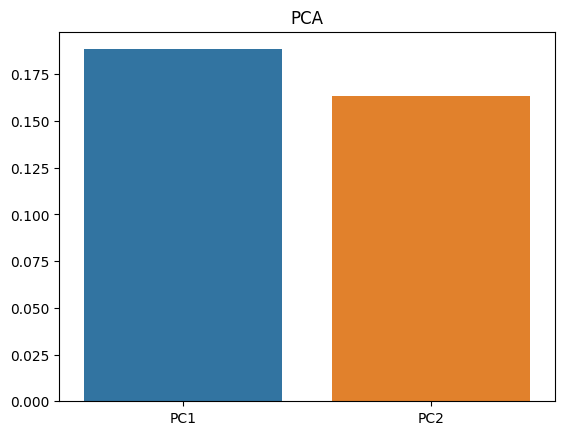

In [7]:
pca.explained_variance_ratio_           # variancia de la "PC1" i "PC2" generades
pca.explained_variance_ratio_.sum()     # variancia total

plt.figure()
plt.title("PCA")
sns.barplot(x=["PC1", "PC2"], y=pca.explained_variance_ratio_)

#### Primeros resultados
Podemos ver que el PCA ha conseguido obtener dos componentes con una variancia bastante elevada.

Ahora passaremos a ver a partir de que atributos se generan estos dos componentes principales.

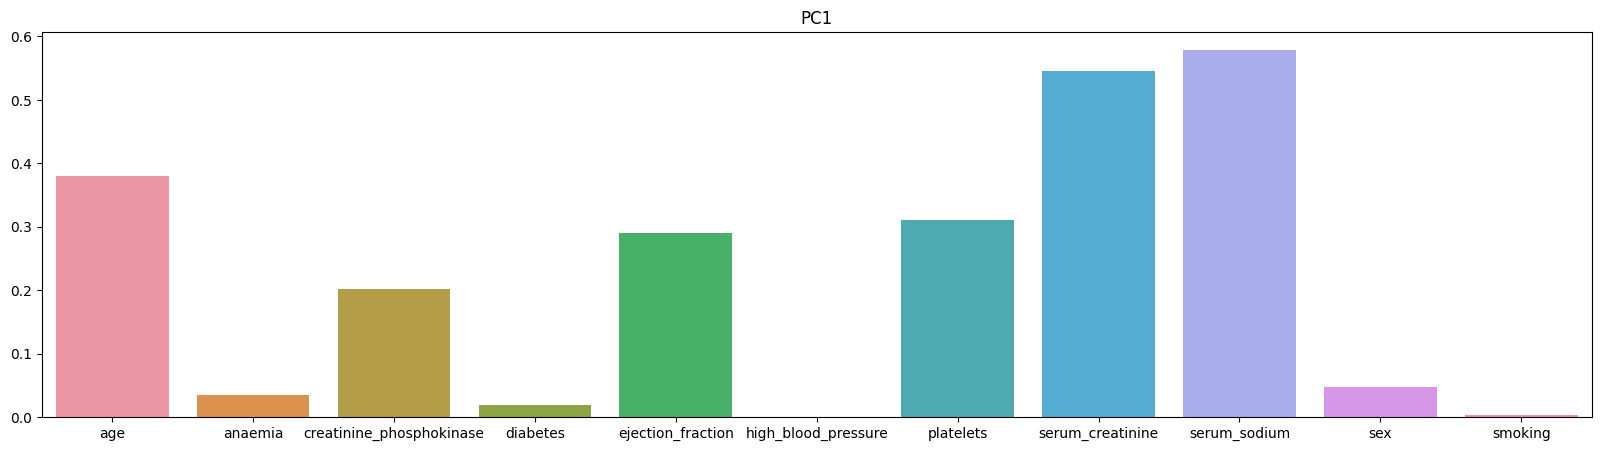

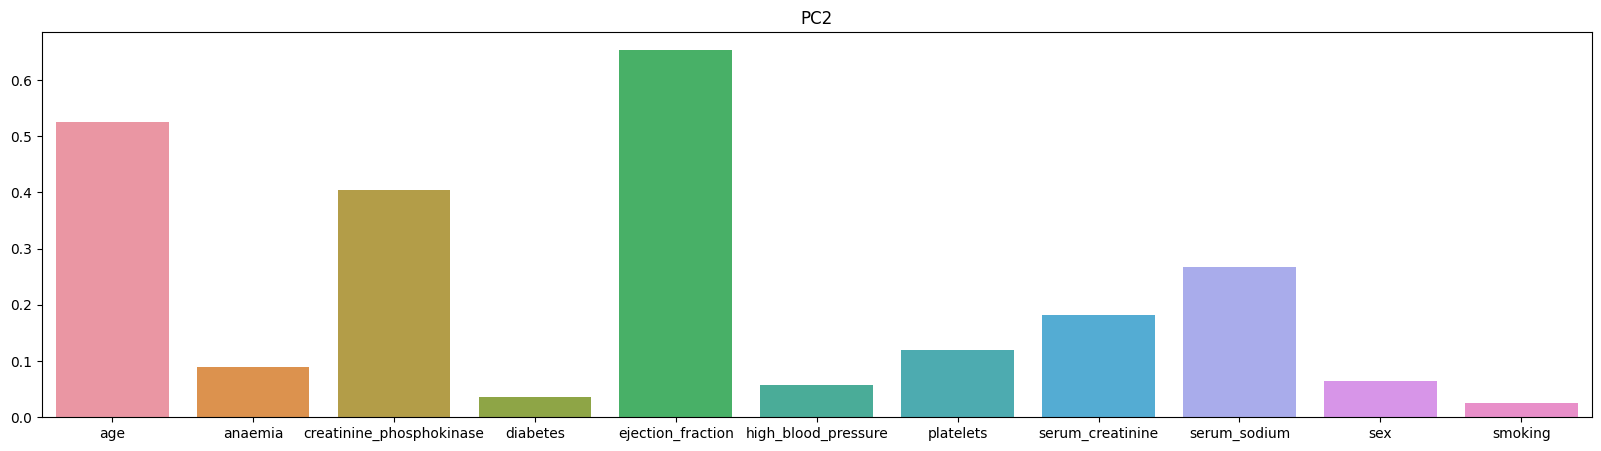

In [8]:
plt.figure(figsize=(20, 5))
plt.title("PC1")
sns.barplot(x=data_norm.columns[0:-2], y=abs(pca.components_[0]))
plt.show()

plt.figure(figsize=(20, 5))
plt.title("PC2")
sns.barplot(x=data_norm.columns[0:-2], y=abs(pca.components_[1]))
plt.show()

#### Analisis de atributos del PCA

Podemos ver que los atributos que proporcionan una mayor variancia en el PC1 son: (ordenados de mayor influencia a menor)
- El suero de creatinina
- El suero de sodio
- La edad
- Numero de plaquetas (celula que influye en la coagulacion de la sangre)
- La fraccion de ejeccion
- La creatininia phosphokinoasa
Los atributos del PC2 no cambian mucho pero se le deja de dar importancia a los dos atributos que influian mas en el componente anterior y por lo tanto los atributos que proporcionan una mayor variancia en el PC2 son: (ordenados de mayor influencia a menor)
- La fraccion de ejeccion
- La edad
- La creatinina phosphokinoasa
- El suero de sodio
- El suero de creatinina

Finalmente se muestra el grafico con los datos transformados por el PCA:

<AxesSubplot: xlabel='PC1', ylabel='PC2'>

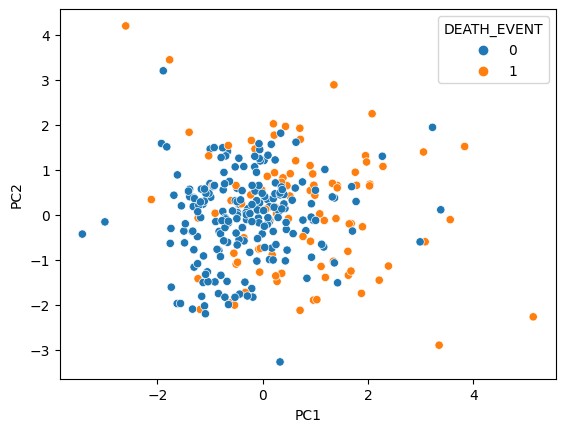

In [9]:
sns.scatterplot(x="PC1", y="PC2", hue=df_pca_g["DEATH_EVENT"], data=df_pca_g)

#### Resultados del PCA
Como podemos ver en el grafico el PCA no logra obtener una diferenciacion lo suficientemente grande para poder separar los datos correctamente. Se puede observar que hay una diferencia de densidad entre las muestras azules y naranjas (persona que ha muerto o ha sido censurada), pero esta diferencia no es lo suficientemente grande como para que podamos separarlas facilmente.

Quizas con un numero mayor de componentes se podria visualizar una separacion mayor, pero el PCA no se suele utilizar para clasificacion sino para obtener un analisis de componentes y saber que atributos se podrian eliminar sin consecuencia.


## Generacion de modelos inicial
En los siguientes apartados desarrollaremos varios modelos para separar ambas clases.

Estos modelos se generaran con parametros por defecto y al final ajustaremos aquellos modelos que nos hayan dado mejores resultados.

### Preparacion de datos
Primero de todo separaremos los datos en los atributos `X` y `y` y despues los separaremos en los datos de train y test.


In [10]:
from sklearn.model_selection import train_test_split
train_test = data_norm.copy()
train_test.pop('time')              # eliminamos esta columna ya que es de resultados
y = train_test.pop('DEATH_EVENT')
X = train_test

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking
6,1.192945,1,-0.346704,0,-1.953749,0,-1.396531e+00,-0.187726,0.085034,1,0
183,1.192945,0,-0.498459,0,-0.007077,1,-4.030910e-01,1.071014,-0.595996,1,0
185,-0.014054,1,-0.493297,1,-0.684180,0,1.286781e+00,0.102752,-0.141976,1,0
146,-0.743913,0,-0.464392,0,-0.684180,0,-4.645409e-01,-0.671857,-0.141976,1,1
30,2.792959,0,0.000166,1,-0.007077,1,7.535660e-09,0.422279,-0.595996,1,0
...,...,...,...,...,...,...,...,...,...,...,...
188,-0.014054,1,-0.444777,1,0.162199,1,-6.386489e-01,-0.381379,-0.141976,0,0
71,-0.238646,0,0.000166,1,-0.260991,0,-1.447739e+00,-0.478205,0.539054,1,1
106,-0.491279,0,0.171536,0,0.585389,0,-3.666809e-03,-0.090900,0.085034,1,0
270,-1.417603,0,0.000166,1,-0.684180,1,7.535660e-09,0.199578,-1.504036,1,1


### Decision tree

Como primer modelo a entrenar se utilizara un decision tree, ya que es un clasificador relativamente sencillo y no lineal.

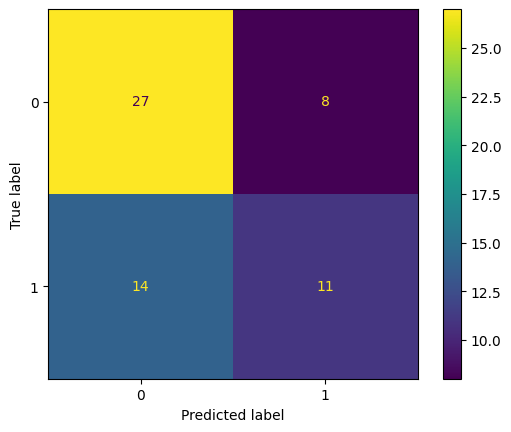

In [11]:
from sklearn import tree
from sklearn.metrics import ConfusionMatrixDisplay

model = tree.DecisionTreeClassifier()
model = model.fit(X_train, y_train)

y_pred = model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

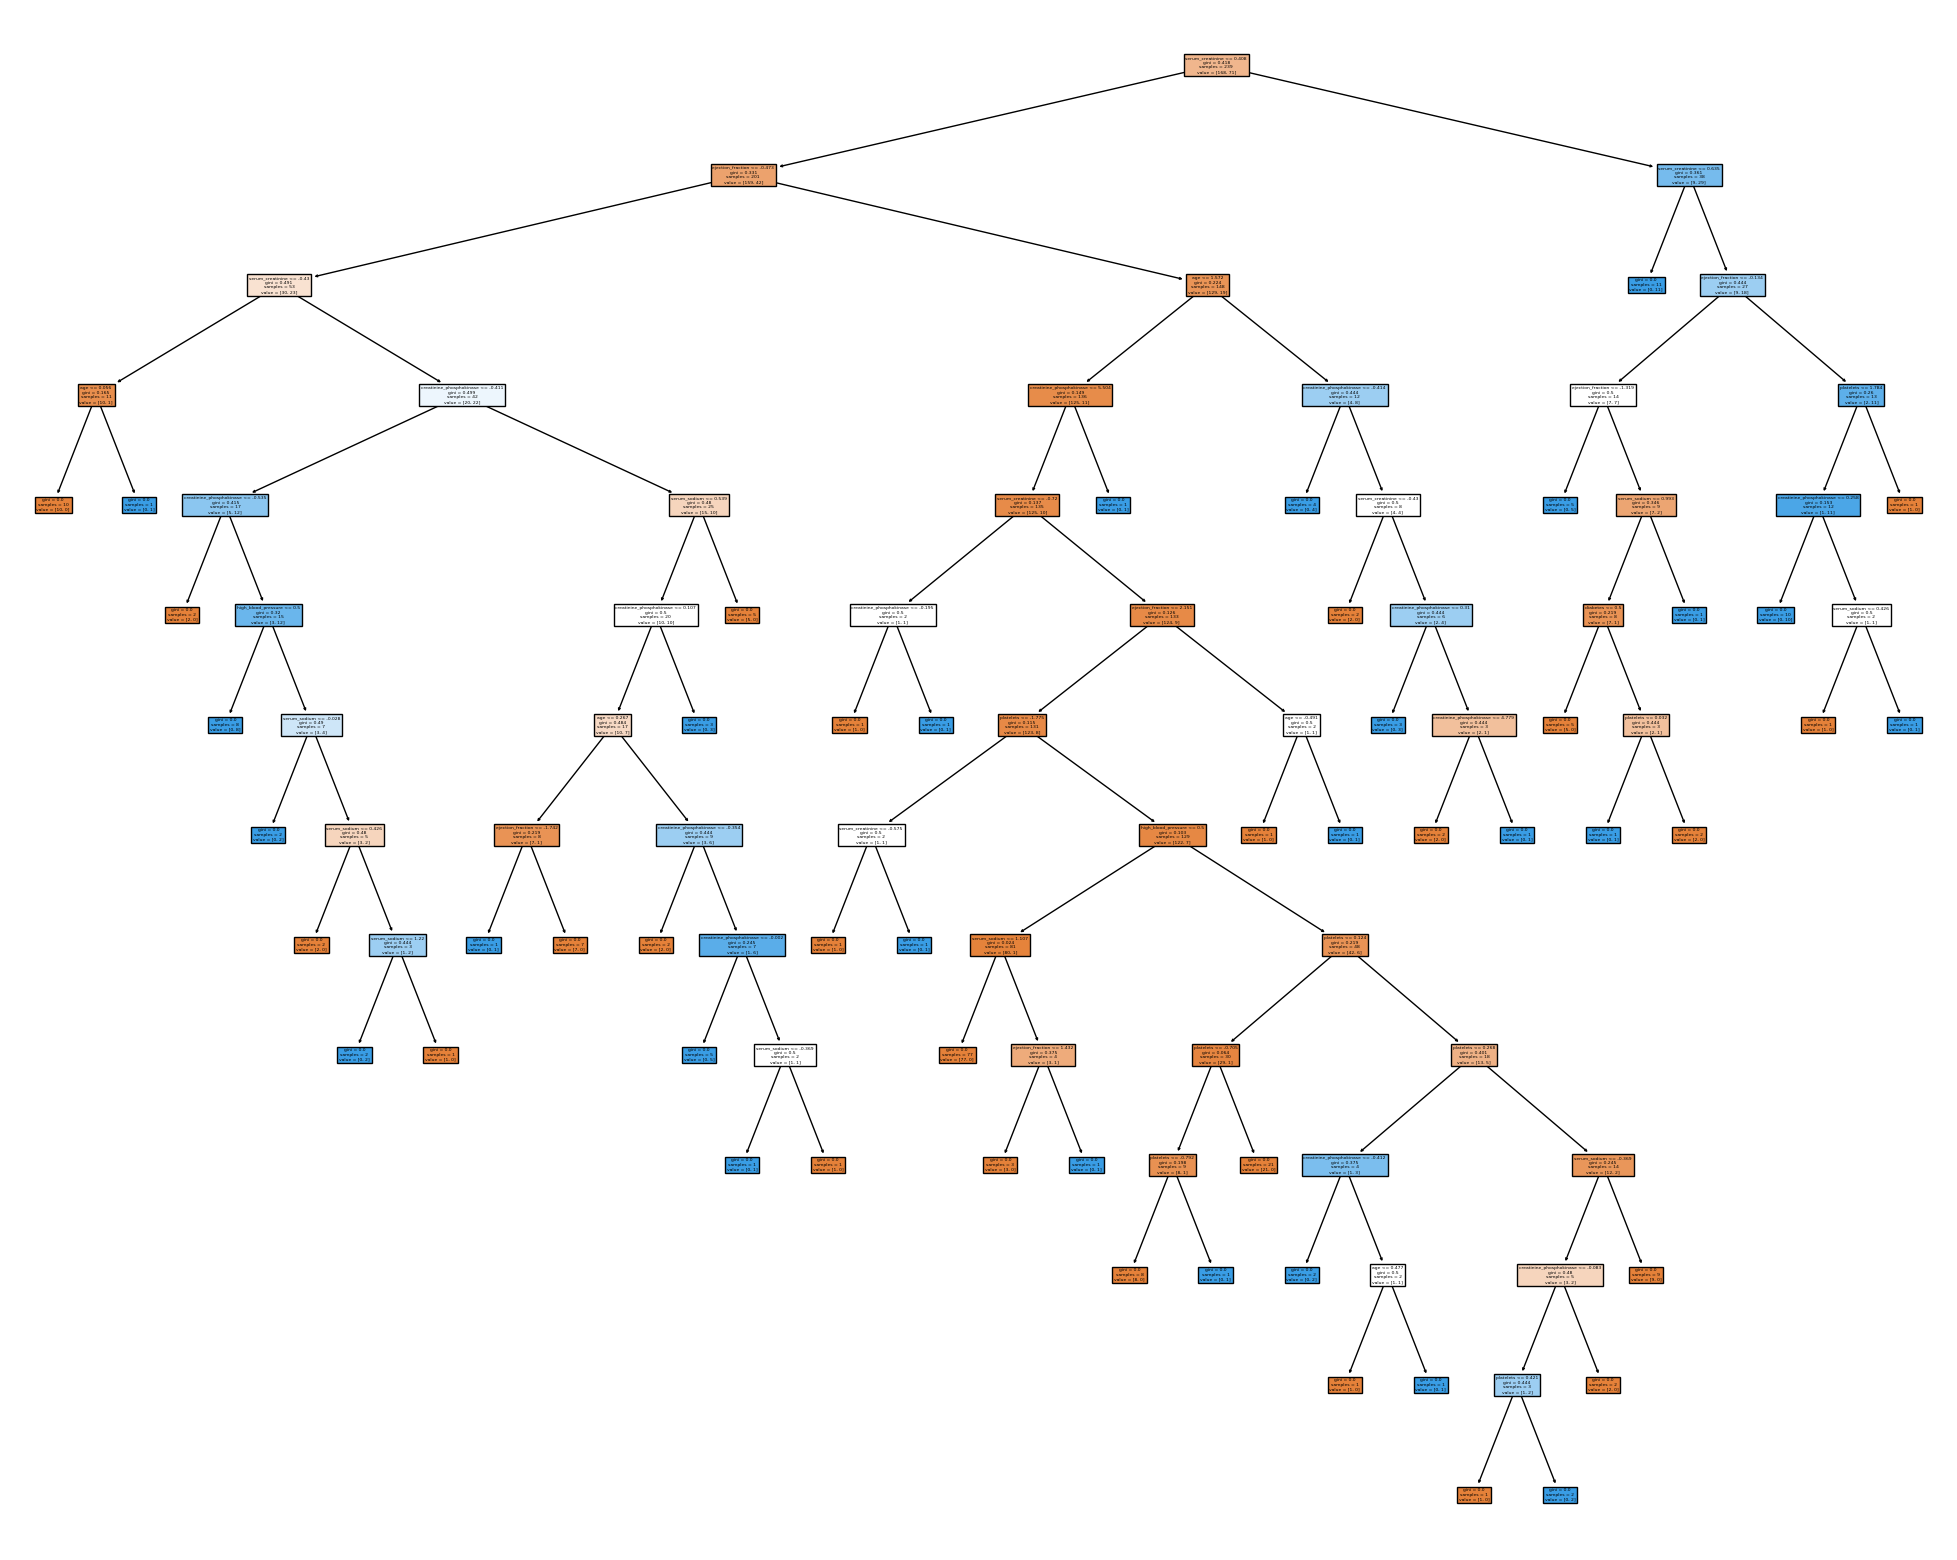

In [12]:
fig = plt.figure(figsize=(25,20))
tree.plot_tree(model, feature_names=X_train.columns, filled=True)
fig.show()

#### Resultados
##### Matriz de confusion
Como podemos ver en la grafica no hemos podido obtener unos buenos resultados.
De las 25 muestras que habia en el test que han sido mortales solo hemos podido predecir 12.
##### Arbol generado
Podemos ver que el arbol hace unas separaciones bastante claras en algunos casos pero no consigue separar bien las muestras en otros. Tambien se puede observar como hay una rama en la cual se tiene que especificar mucho para separar entre ambas clases y por lo tanto acaba generando muchas ramas y obtiene una profundidad bastante elevada. Hay ramas generadas por incluso 13 nodos.

#### Proximos modelos
En las proximos modelos nos centraremos en intentar aumentar esta metrica, es decir en aumentar todo lo posible el recall aunque por ello perdamos precision.

### Random forest
Probaremos a utilizar un random forest para ver si este obtiene mejores resultados al utilizar menos atributos y ser generado aleatoriamente.

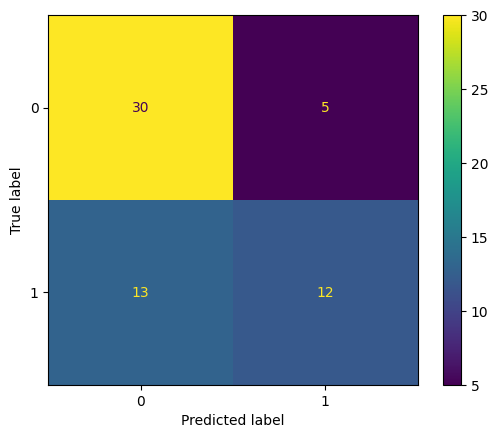

In [13]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

#### Resultados
El rendimiento del modelo se mantiene constante, pero hemos mejorado en otra metrica:

Obtenemos una mayor precision que con el decision tree simple (antes: 12/21, ahora: 12/17).


### Modelos mas especificos
Como hemos podido observar los modelos que hemos escogido no han obtenido resultados lo suficientemente buenos como para poder obtener un recall alto.
Utilizaremos la siguiente grafica para escoger los modelos que entrenaremos a continuacion:

![images/scikit-learn-algorithms.png](images/scikit-learn-algorithms.png)

A partir de esta grafica podemos elejir que modelo utilizar segun nuestras necesidades.

En nuestro caso tenemos mas de 50 muestras, predecimos una categoria y tenemos datos con etiquetas (el atributo `DEATH_EVENT`), por lo tanto tenemos un problema de clasificacion.
A partir de esto continuamos con el grafo, tenemos menos de 100K muestras por lo tanto probaremos un Linear SVC, en caso de que no funcione como no tenemos datos con texto utilizaremos en Knn y si este no funciona utilizaremos SVC mas complejos y clasificadores ensemble.

### Linear SVC
Un SVC lineal deberia de separar las clases rapidamente si estas son separables linealmente. Como es muy improbable que esto suceda estableceremos un soft-margin para que tarde menos.

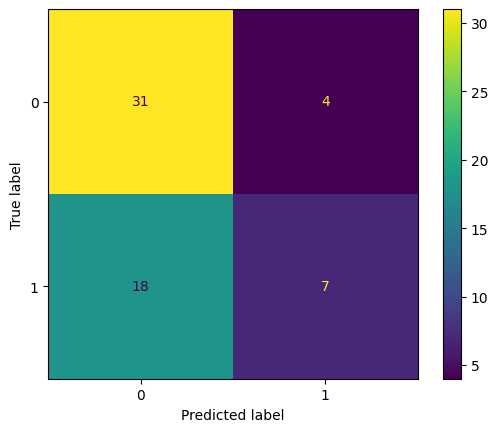

In [14]:
from sklearn.svm import SVC

model = SVC(kernel="linear")
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

#### Resultados
Podemos observar que el recall no es muy bueno. Es tan solo de 7/25 a comparacion con el decision tree este es un resultado bastante pobre de manera que continuaremos con los siguientes modelos que aparecian en el grafico.

### KNeighbors
Como el SVC lineal no ha podido clasificar correctamente utilizaremos el siguiente clasificador que aparecia en la grafica, es decir el clasificador KNeighbors.

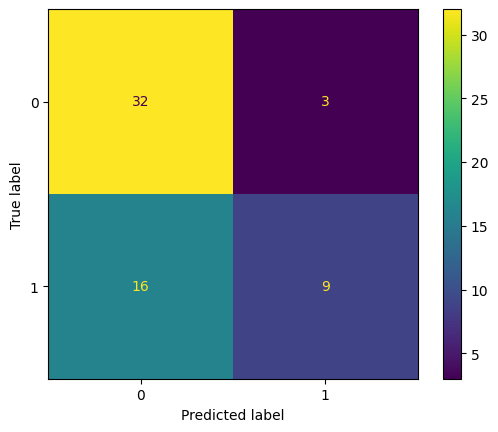

In [35]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

#### Resultados
Obtenemos una mejora del SVC lineal en relacion a ambas metricas mencionadas en apartados anteriores, el precision y el recall. Por desgracia estos resultados no son tan buenos como el decision tree, por lo tanto seguiremos probando distintos modelos.

### SVC
Probaremos diversos kernels del SVC para comprobar todas las opciones posibles, como ya hemos comprobado el kernel lineal solo tendremos que comprobar el kernel rfb, el kernel polinomico y el kernel sigmoidea.

#### Kernel polinomico

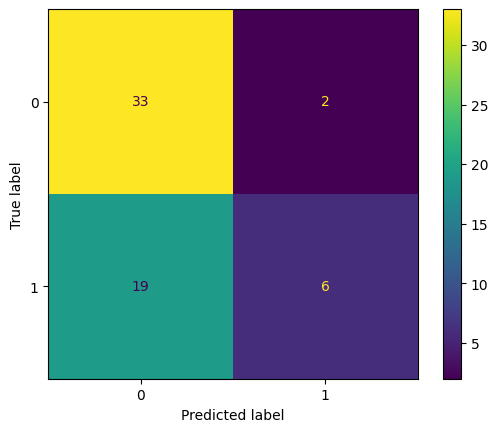

In [16]:
from sklearn.svm import SVC

model = SVC(kernel="poly")
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

##### Resultados
Perdemos recall frente a otros clasificadores por lo tanto este kernel no funciona en nuestro problema.

#### Kernel rbf

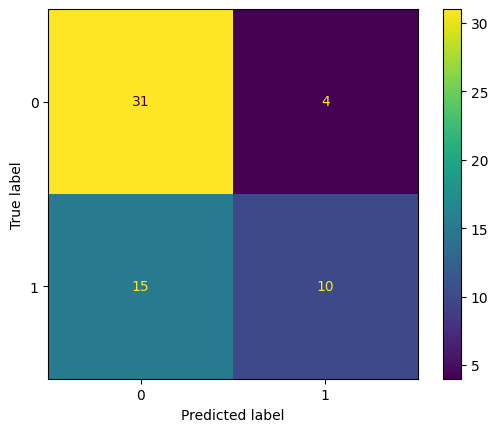

In [18]:
from sklearn.svm import SVC

model = SVC(kernel="rbf")
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

##### Resultados
Obtiene un buen recall comparado con otros modelos probados, pero sigue sin ser tan bueno como el decision tree.

#### Kernel sigmoidea

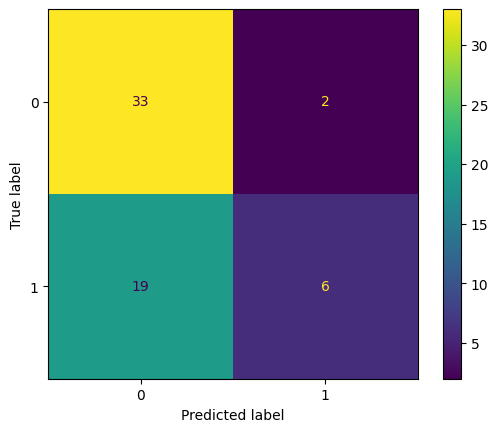

In [19]:
from sklearn.svm import SVC

model = SVC(kernel="sigmoid")
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

##### Resultados
Obtenemos resultados exactamente iguales a los del kernel polinomico, por lo tanto este kernel no funciona para nuestro problema.

#### Resultados finales del SVC
Los resultados no han sido muy buenos en general. Cabe destacar que el kernel rbf ha funcionado bastante bien y probablemente se intentara mejorar con distintos parametros en los proximos apartados.

De todas formas no se han obtenido los resultados esperados y continuaremos probando modelos distintos.

### Ensemble Classifiers
Los clasificadores ensemble utilizan multiples modelos simples para obtener una prediccion correcta.

En este apartado probaremos diversos clasificadores.

#### ADA Boost


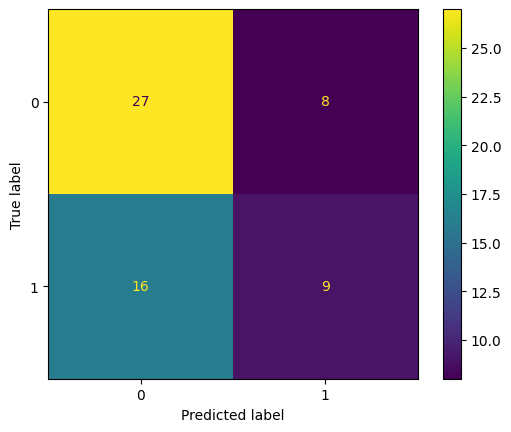

In [31]:
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

##### Resultados
No se obtienen resultados buenos a partir de este clasificador.

#### Extremely randomized trees

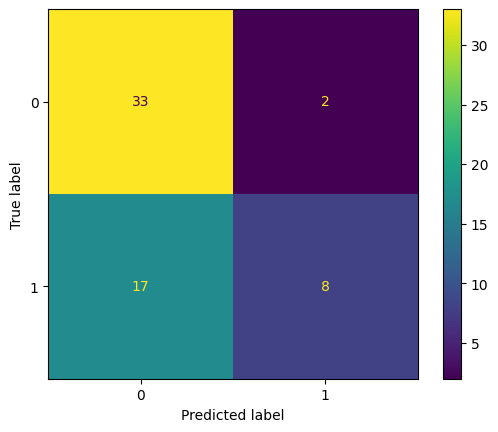

In [30]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

##### Resultados
Se obtiene una buena precision, pero el recall sigue siendo bastante bajo.

### Resultados de la generacion de modelos inicial
A partir de estos modelos generados escogeremos aquellos que hayan obtenido un buen rendimiento y consideramos que podrian mejorar cambiando algunos hiperparametros del clasificador.

Los modelos escogidos son:
- Decision Tree
- Random forest
- SVC con kernel rbf
- El clasificador Extremely randomized trees


## Mejora de los modelos

En este apartado nos centraremos en mejorar los hiperparametros de los modelos escogidos en el apartado anterior.
### Metodos utilizados
Utilizaremos un grid search para obtener unos parametros generales y seguidamente un random search segun los resultados del apartado anterior.

### Decision Tree


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END criterion=gini, max_depth=None, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=None, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=None, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=None, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=None, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=None, min_samples_split=4; total time=   0.0s
[CV] END criterion=gini, max_depth=None, min_samples_split=4; total time=   0.0s
[CV] END criterion=gini, max_depth=None, min_samples_split=4; total time=   0.0s
[CV] END criterion=gini, max_depth=None, min_samples_split=4; total time=   0.0s
[CV] END criterion=gini, max_depth=None, min_samples_split=4; total time=   0.0s
[CV] END criterion=gini, max_depth=None, min_samples_split=8; total time=   0.0s
[CV] END criterion=gini, max_depth=None, min_sa

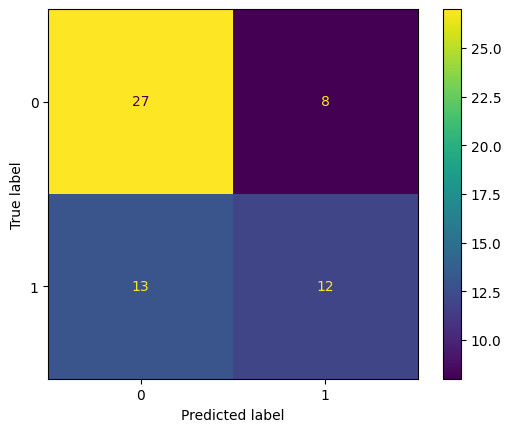

In [39]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

## Support Vector Machine Linear Kernel

param_grid = [
    {
        'criterion': ["gini", "entropy", "log_loss"],
        'min_samples_split' : [2, 4, 8],
        'max_depth' : [None, 6, 8, 10]
    },
]


grid = GridSearchCV(DecisionTreeClassifier(), param_grid, refit=True, verbose=2, scoring="recall")
grid.fit(X_train,y_train)

print(grid.best_estimator_)

grid_predictions = grid.predict(X_test)
print(classification_report(y_test,grid_predictions))
ConfusionMatrixDisplay.from_predictions(y_test, grid_predictions)
plt.show()

#### Resultados
No se va a intentar obtener parametros mas especificos ya que no se han obtenido mejoras significativas, no hay hiperparametros que puedan hacer mejorar el decision tree.

### Random Forest


Fitting 5 folds for each of 540 candidates, totalling 2700 fits
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=10; total time=   

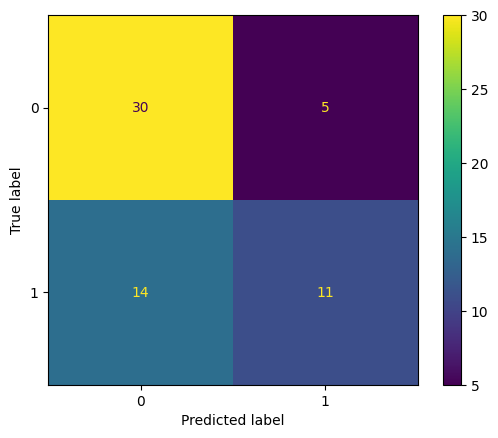

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

## Support Vector Machine Linear Kernel

param_grid = [
    {
        'n_estimators': [100, 10, 1000, 50, 500],
        'criterion': ["gini", "entropy", "log_loss"],
        'min_samples_split' : [2, 4, 8],
        'max_depth' : [None, 6, 8, 10],
        'max_features': ["sqrt", "log2", None]
    },
]

grid = GridSearchCV(RandomForestClassifier(), param_grid, refit=True, verbose=2, scoring="recall")
grid.fit(X_train,y_train)

print(grid.best_estimator_)

grid_predictions = grid.predict(X_test)
print(classification_report(y_test,grid_predictions))
ConfusionMatrixDisplay.from_predictions(y_test, grid_predictions)
plt.show()

#### Resultados
Pese a tener mas parametros no hemos podido encontrar un conjunto de hiperparametros que pudiese mejorar el resultado.


### SVC con kernel rbf


Fitting 5 folds for each of 35 candidates, totalling 175 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.0

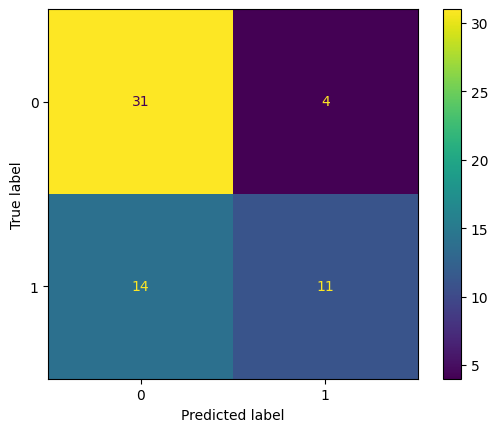

In [41]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

## Support Vector Machine Linear Kernel

param_grid = [
    {
        'C': [0.1, 1, 10, 100, 1000],
        'gamma': [1, 0.1, 0.01, 0.001, 0.0005, 0.0001, 'scale'],
        'kernel': ['rbf']
    },
]

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2, scoring="recall")
grid.fit(X_train,y_train)

print(grid.best_estimator_)

grid_predictions = grid.predict(X_test)
print(classification_report(y_test,grid_predictions))
ConfusionMatrixDisplay.from_predictions(y_test, grid_predictions)
plt.show()

#### Resultados
Los mejo

#### Resultados
Los mejores parametros han sido C=100 y gamma=0.1, por desgracia el rendimiento ha sido peor del esperado.

### Extremely randomized trees

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

## Support Vector Machine Linear Kernel

param_grid = [
    {
        'n_estimators': [100, 10, 1000, 50, 500],
        'criterion': ["gini", "entropy", "log_loss"],
        'min_samples_split' : [2, 4, 8],
        'max_depth' : [None, 6, 8, 10],
        'max_features': ["sqrt", "log2", None]
    },
]

grid = GridSearchCV(ExtraTreesClassifier(), param_grid, refit=True, verbose=2, scoring="recall")
grid.fit(X_train,y_train)

print(grid.best_estimator_)

grid_predictions = grid.predict(X_test)
print(classification_report(y_test,grid_predictions))
ConfusionMatrixDisplay.from_predictions(y_test, grid_predictions)
plt.show()